# Análisis de Actividad de Usuarios

Este notebook se enfoca en el análisis detallado de la actividad de los usuarios en la plataforma Peliplat. Se cargarán los datos de actividad, se calcularán métricas relevantes como días activos, visitas diarias promedio y se explorarán patrones de uso. El objetivo es comprender cómo interactúan los usuarios con la plataforma a lo largo del tiempo.

### 1. Configuración Inicial e Importaciones

Se inicia la configuración del entorno de análisis. Esto incluye:
- La importación de bibliotecas estándar de Python para manipulación de datos (`pandas`, `numpy`), visualización (`matplotlib`, `seaborn`), y manejo de fechas (`datetime`, `calendar`).
- La adición del directorio `src` al `sys.path` para permitir la importación de módulos personalizados.
- La importación de funciones y constantes específicas del proyecto desde `utils.utils_peliplat` (colores, configuración de estilo, guardado de figuras, muestra de tablas).
- La aplicación del estilo visual `Peliplat` a los gráficos que se generarán posteriormente mediante `configurar_estilo_peliplat()`.

In [1]:
# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import calendar
import sys

# Añadir el directorio padre al path para acceder a utils
sys.path.append('../')

# Importar funciones de utils_peliplat
from utils.utils_peliplat import (
    COLORES_PELIPLAT, 
    configurar_estilo_peliplat,
    guardar_figura,
    mostrar_tabla
)

# Configurar el estilo de visualización
configurar_estilo_peliplat()

### 2. Carga y Verificación Inicial de Datos

Se cargan los conjuntos de datos procesados y limpios necesarios para el análisis de actividad desde archivos CSV ubicados en `data/processed/`:
- `peliplat_content_clean.csv`: Contiene información sobre el contenido de la plataforma.
- `peliplat_engagement_clean.csv`: Contiene datos sobre la interacción de los usuarios con el contenido (likes, shares, comments).
- `peliplat_activity_clean.csv`: Contiene registros de la actividad de los usuarios (visitas, fechas).

Para asegurar que la carga se ha realizado correctamente y tener una primera impresión de la estructura de los datos, se muestran las primeras cinco filas de cada DataFrame (`content`, `engagement`, `activity`) utilizando `display(df.head())`.

In [2]:
# Cargar los datos necesarios
content = pd.read_csv('../data/processed/peliplat_content_clean.csv')
engagement = pd.read_csv('../data/processed/peliplat_engagement_clean.csv')
activity = pd.read_csv('../data/processed/peliplat_activity_clean.csv')

# Mostrar las primeras filas de cada DataFrame para verificar
print("Muestra de datos de contenido:")
display(content.head())

print("\nMuestra de datos de engagement:")
display(engagement.head())

print("\nMuestra de datos de actividad:")
display(activity.head())

Muestra de datos de contenido:


,content_id,creator_id,type,category,publish_date,visits
0,C0000,CR21,Artículo,Mainstream,2025-01-10,48
1,C0001,CR4,Artículo,Documental,2025-01-30,55
2,C0002,CR1,Lista,Documental,2025-01-25,61
3,C0003,CR24,Lista,Clásicos,2025-03-25,55
4,C0004,CR9,Lista,Clásicos,2025-01-05,39



Muestra de datos de engagement:


,user_id,content_id,likes,shares,comments
0,U0073,C0048,2,1,0
1,U0191,C0189,3,1,1
2,U0004,C0135,3,0,1
3,U0099,C0042,3,1,2
4,U0069,C0089,2,0,1



Muestra de datos de actividad:


,user_id,avg_daily_visits,avg_time_on_page,most_viewed_type
0,U0000,0.83,261.7,Lista
1,U0001,0.57,261.7,Artículo
2,U0002,2.68,261.7,Video
3,U0003,0.97,261.7,Lista
4,U0004,0.83,261.7,Lista


### 3. Procesamiento de Fechas y Fusión de Datos

Se realizan varios pasos de preprocesamiento para preparar los datos para el análisis temporal:

1.  **Conversión de Fechas:** La columna `publish_date` en el DataFrame `content` se convierte al tipo de dato `datetime` para permitir operaciones basadas en fechas.
2.  **Extracción de Características Temporales:** Se extraen el nombre del día de la semana (`dia_semana`) y el nombre del mes (`mes`) a partir de la columna `publish_date` y se añaden como nuevas columnas al DataFrame `content`.
3.  **Fusión de Datos (`merge`):** Se combina el DataFrame `engagement` con una selección de columnas del DataFrame `content` (incluyendo las nuevas características temporales y metadatos como `type` y `category`) utilizando `content_id` como clave. El resultado (`engagement_con_fecha`) es un DataFrame que asocia cada interacción con la fecha de publicación y características del contenido correspondiente. Se utiliza una unión izquierda (`how='left'`) para conservar todos los registros de `engagement`.
4.  **Cálculo de Interacción Total:** Se crea una nueva columna `interaccion_total` sumando las columnas `likes`, `shares` y `comments` en el DataFrame `engagement_con_fecha`.
5.  **Resumen Básico:** Finalmente, se imprime un resumen conciso que incluye el número total de piezas de contenido, el número total de registros de interacción y el rango de fechas cubierto por las fechas de publicación del contenido.

In [3]:
# Convertir la columna de fecha a datetime
content['publish_date'] = pd.to_datetime(content['publish_date'])

# Crear columnas temporales
content['dia_semana'] = content['publish_date'].dt.day_name()
content['mes'] = content['publish_date'].dt.month_name()

# Unir datos de engagement con fechas de contenido
engagement_con_fecha = engagement.merge(
    content[['content_id', 'publish_date', 'dia_semana', 'mes', 'type', 'category']],
    on='content_id',
    how='left'
)

# Agregar columna de interacción total
engagement_con_fecha['interaccion_total'] = (
    engagement_con_fecha['likes'] + 
    engagement_con_fecha['shares'] + 
    engagement_con_fecha['comments']
)

# Resumen de los datos
print("Resumen de los datos:")
print(f"Total de contenidos: {len(content)}")
print(f"Total de interacciones: {len(engagement)}")
print(f"Periodo de fechas: {content['publish_date'].min().strftime('%Y-%m-%d')} a {content['publish_date'].max().strftime('%Y-%m-%d')}")

Resumen de los datos:
Total de contenidos: 300
Total de interacciones: 498
Periodo de fechas: 2025-01-01 a 2025-03-31


### 4. Análisis Agregado por Día de la Semana

Se investiga cómo varían las visitas al contenido y las interacciones totales según el día de la semana en que se publicó el contenido.

1.  **Análisis de Visitas:**
    *   Se agrupan los datos del DataFrame `content` por la columna `dia_semana`.
    *   Para cada día, se calcula la suma total de visitas (`total_visitas`), el promedio de visitas por contenido (`promedio_visitas`) y la cantidad de contenidos publicados (`contenidos`).
    *   Los resultados se redondean y se ordenan cronológicamente de lunes a domingo.
2.  **Análisis de Engagement:**
    *   Se agrupan los datos del DataFrame `engagement_con_fecha` (que incluye la fecha de publicación del contenido asociado a cada interacción) por `dia_semana`.
    *   Para cada día, se calcula la suma total de interacciones (`total_interacciones`), el promedio de interacciones por evento de engagement (`promedio_interacciones`) y el número de interacciones registradas (`count`).
    *   Los resultados se redondean y se ordenan cronológicamente.
3.  **Presentación de Resultados:**
    *   Los DataFrames resultantes (`visitas_por_dia` y `engagement_por_dia`) se presentan como tablas formateadas utilizando la función `mostrar_tabla`.
    *   Cada tabla recibe un título descriptivo y se guarda en un archivo HTML independiente (`visitas_por_dia.html` e `interacciones_por_dia.html`) para referencia externa.

In [4]:
# Análisis de visitas por día de la semana
visitas_por_dia = content.groupby('dia_semana')['visits'].agg([
    ('total_visitas', 'sum'),
    ('promedio_visitas', 'mean'),
    ('contenidos', 'count')
]).round(2)

# Ordenar los días de la semana correctamente
orden_dias = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
visitas_por_dia = visitas_por_dia.reindex(orden_dias)

# Análisis de engagement por día de la semana
engagement_por_dia = engagement_con_fecha.groupby('dia_semana')['interaccion_total'].agg([
    ('total_interacciones', 'sum'),
    ('promedio_interacciones', 'mean'),
    ('count', 'count')
]).round(2)

engagement_por_dia = engagement_por_dia.reindex(orden_dias)

# Mostrar las tablas
mostrar_tabla(
    visitas_por_dia,
    titulo="Visitas por Día de la Semana",
    guardar=True,
    nombre_archivo="visitas_por_dia.html"
)

mostrar_tabla(
    engagement_por_dia,
    titulo="Interacciones por Día de la Semana",
    guardar=True,
    nombre_archivo="interacciones_por_dia.html"
)


Visitas por Día de la Semana


,total_visitas,promedio_visitas,contenidos
dia_semana,,,
Monday,1838,48.37,38
Tuesday,2003,50.08,40
Wednesday,1867,49.13,38
Thursday,1890,51.08,37
Friday,2148,49.95,43
Saturday,3078,50.46,61
Sunday,2181,50.72,43


Tabla guardada en HTML: ../reports/tables\visitas_por_dia.html
Tabla guardada en PNG: ../reports/tables\visitas_por_dia.png

Interacciones por Día de la Semana


,total_interacciones,promedio_interacciones,count
dia_semana,,,
Monday,235,3.56,66
Tuesday,191,3.13,61
Wednesday,217,3.50,62
Thursday,190,3.11,61
Friday,239,3.46,69
Saturday,358,3.09,116
Sunday,217,3.44,63


Tabla guardada en HTML: ../reports/tables\interacciones_por_dia.html
Tabla guardada en PNG: ../reports/tables\interacciones_por_dia.png


### 5. Visualización de Patrones de Actividad Semanal

Se crea una figura compuesta por cuatro gráficos de barras para visualizar los patrones de actividad y engagement agregados por día de la semana, utilizando los DataFrames `visitas_por_dia` y `engagement_por_dia` calculados previamente.

La figura se organiza en una cuadrícula de 2x2:

1.  **Gráfico Superior Izquierdo:** Muestra el **total de visitas** recibidas por el contenido publicado en cada día de la semana.
2.  **Gráfico Superior Derecho:** Ilustra el **promedio de visitas** por contenido para cada día de la semana de publicación.
3.  **Gráfico Inferior Izquierdo:** Representa la **cantidad de contenidos** publicados en cada día de la semana.
4.  **Gráfico Inferior Derecho:** Muestra el **promedio de interacciones totales** por evento de engagement, agrupado por el día de la semana en que se publicó el contenido asociado.

Cada subgráfico utiliza colores distintos definidos en `COLORES_PELIPLAT` para diferenciar las métricas. Se configuran títulos individuales para cada subgráfico y un título general (`suptitle`) para la figura completa. Se aplica `tight_layout` para optimizar el espaciado, se guarda la figura resultante como `patrones_actividad_semanal.png` y finalmente se muestra.

Figura guardada en: ../reports/figures\patrones_actividad_semanal.png


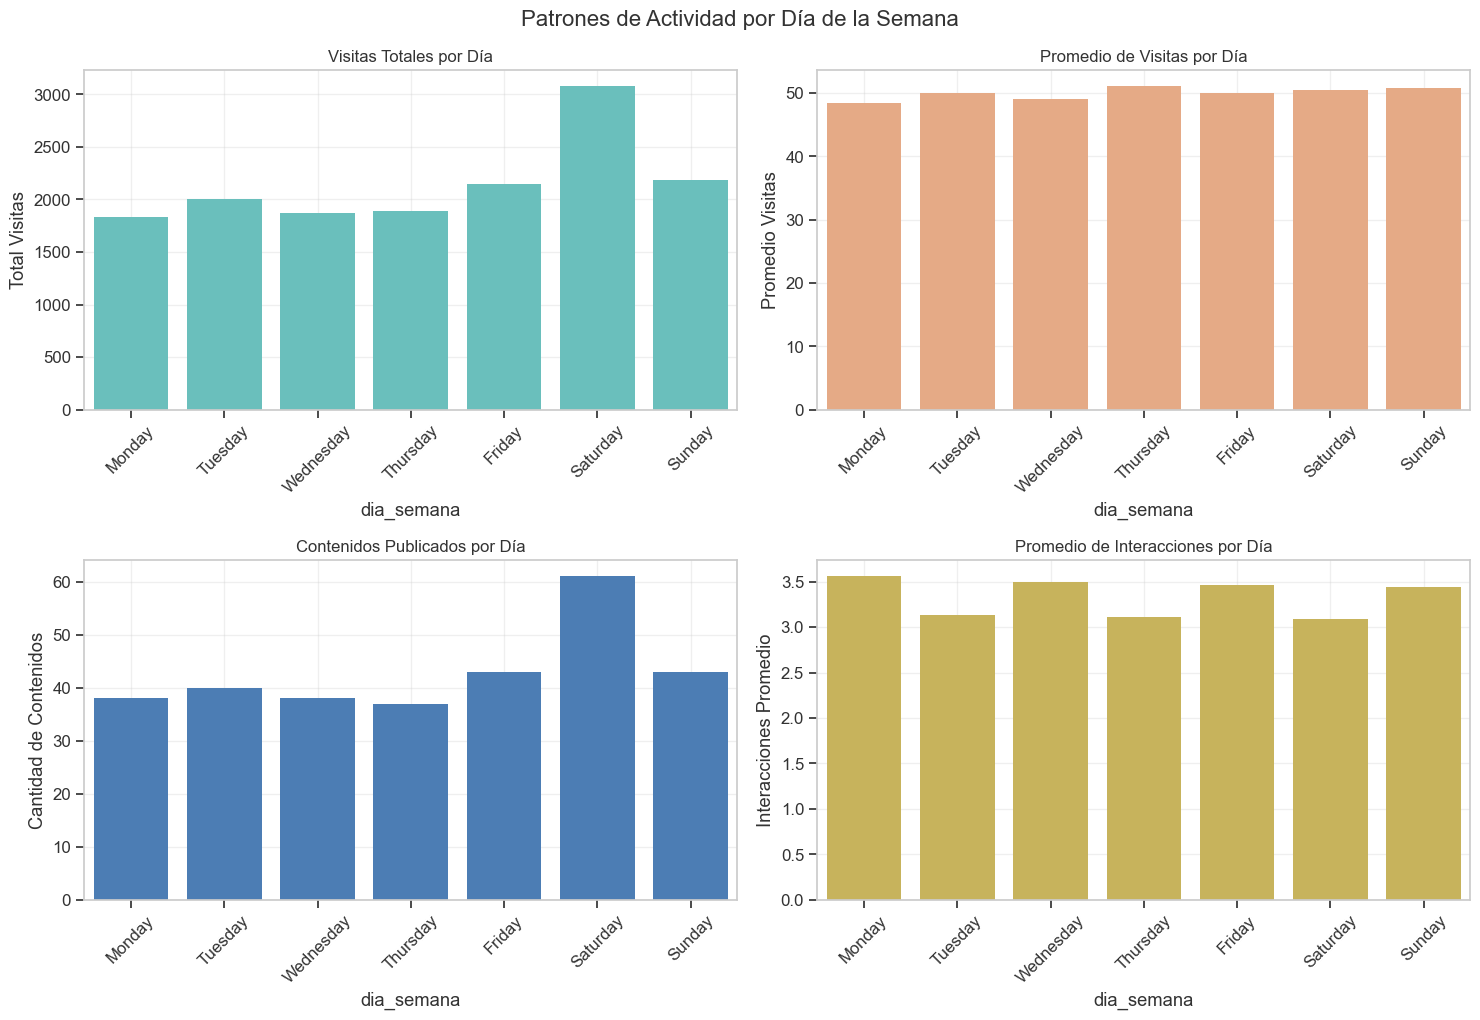

In [5]:
# Configuración de visualización
plt.figure(figsize=(15, 10))
configurar_estilo_peliplat()

# 1. Gráfico de barras de visitas totales por día
plt.subplot(2, 2, 1)
sns.barplot(
    x=visitas_por_dia.index,
    y='total_visitas',
    data=visitas_por_dia,
    color=COLORES_PELIPLAT['turquesa']
)
plt.title('Visitas Totales por Día', fontsize=12, color=COLORES_PELIPLAT['texto'])
plt.ylabel('Total Visitas')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)

# 2. Gráfico de barras de promedio de visitas por día
plt.subplot(2, 2, 2)
sns.barplot(
    x=visitas_por_dia.index,
    y='promedio_visitas',
    data=visitas_por_dia,
    color=COLORES_PELIPLAT['secundario']
)
plt.title('Promedio de Visitas por Día', fontsize=12, color=COLORES_PELIPLAT['texto'])
plt.ylabel('Promedio Visitas')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)

# 3. Gráfico de barras de contenidos publicados por día
plt.subplot(2, 2, 3)
sns.barplot(
    x=visitas_por_dia.index,
    y='contenidos',
    data=visitas_por_dia,
    color=COLORES_PELIPLAT['azul']
)
plt.title('Contenidos Publicados por Día', fontsize=12, color=COLORES_PELIPLAT['texto'])
plt.ylabel('Cantidad de Contenidos')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)

# 4. Gráfico de barras de interacciones promedio por día
plt.subplot(2, 2, 4)
sns.barplot(
    x=engagement_por_dia.index,
    y='promedio_interacciones',
    data=engagement_por_dia,
    color=COLORES_PELIPLAT['amarillo']
)
plt.title('Promedio de Interacciones por Día', fontsize=12, color=COLORES_PELIPLAT['texto'])
plt.ylabel('Interacciones Promedio')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.suptitle('Patrones de Actividad por Día de la Semana', fontsize=16, color=COLORES_PELIPLAT['texto'], y=1.02)
guardar_figura(plt.gcf(), 'patrones_actividad_semanal.png')
plt.show()

### 6. Análisis Detallado por Día de la Semana y Tipo de Contenido

Se profundiza el análisis anterior examinando las métricas de visitas de forma combinada por día de la semana y tipo de contenido (`Artículo`, `Lista`, `Video`).

1.  **Agregación Doble:** Se agrupa el DataFrame `content` utilizando tanto `dia_semana` como `type`. Para cada combinación (ej. Lunes-Artículo, Lunes-Video, Martes-Artículo, etc.), se calculan la suma total de visitas, el promedio de visitas y la cantidad de contenidos publicados.
2.  **Reestructuración:** Los resultados de la agregación se reestructuran para asegurar que todas las combinaciones posibles de día y tipo estén presentes, incluso si no hubo contenido de un tipo específico publicado en un día determinado. Se crea un DataFrame (`tabla_combinada`) con un MultiIndex (día, tipo) y se rellena con los datos agregados. Las combinaciones faltantes se completan con ceros.
3.  **Presentación:** La tabla resultante (`tabla_combinada`), que ofrece una vista detallada de la actividad por día y tipo, se muestra utilizando `mostrar_tabla`. Se le asigna un título descriptivo y se guarda en formato HTML (`actividad_dia_tipo_combinada.html`).

In [6]:
# Análisis por día y tipo
actividad_por_dia_tipo = content.groupby(['dia_semana', 'type']).agg({
    'visits': ['sum', 'mean', 'count']
}).round(2)

# Renombrar para claridad
actividad_por_dia_tipo.columns = ['total_visitas', 'promedio_visitas', 'cantidad']
actividad_por_dia_tipo = actividad_por_dia_tipo.reset_index()

# Crear una tabla combinada con todas las métricas
tabla_combinada = pd.DataFrame(index=pd.MultiIndex.from_product([
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    ['Artículo', 'Lista', 'Video']
], names=['dia_semana', 'type']))

# Agregar los datos a la tabla combinada
for dia in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']:
    for tipo in ['Artículo', 'Lista', 'Video']:
        filtro = (actividad_por_dia_tipo['dia_semana'] == dia) & (actividad_por_dia_tipo['type'] == tipo)
        if filtro.any():
            datos = actividad_por_dia_tipo[filtro].iloc[0]
            tabla_combinada.loc[(dia, tipo), 'Visitas Totales'] = datos['total_visitas']
            tabla_combinada.loc[(dia, tipo), 'Promedio Visitas'] = datos['promedio_visitas']
            tabla_combinada.loc[(dia, tipo), 'Cantidad'] = datos['cantidad']

# Rellenar NaN con ceros
tabla_combinada = tabla_combinada.fillna(0)

# Mostrar tabla en formato ancho
print("Análisis completo por día y tipo de contenido:")
mostrar_tabla(
    tabla_combinada,
    titulo="Actividad por Día y Tipo de Contenido",
    guardar=True,
    nombre_archivo="actividad_dia_tipo_combinada.html"
)

Análisis completo por día y tipo de contenido:

Actividad por Día y Tipo de Contenido


Tabla guardada en HTML: ../reports/tables\actividad_dia_tipo_combinada.html
Tabla guardada en PNG: ../reports/tables\actividad_dia_tipo_combinada.png


### 7. Análisis Detallado por Día de la Semana y Categoría de Contenido

De forma análoga al análisis por tipo de contenido, se examinan ahora las métricas de visitas combinando el día de la semana y la categoría del contenido.

1.  **Agregación por Categoría:** Se agrupa el DataFrame `content` utilizando `dia_semana` y `category`. Para cada combinación (ej. Lunes-Ciencia Ficción, Lunes-Comedia, etc.), se calculan la suma total de visitas, el promedio de visitas y la cantidad de contenidos publicados.
2.  **Reestructuración por Categoría:** Se identifican todas las categorías únicas presentes en los datos. Se crea un DataFrame (`tabla_combinada_categoria`) con un MultiIndex (día, categoría) que incluye todas las combinaciones posibles. Los datos agregados se insertan en esta estructura, y las combinaciones sin datos se rellenan con cero.
3.  **Presentación:** La tabla resultante (`tabla_combinada_categoria`), que desglosa la actividad por día y categoría temática, se visualiza mediante `mostrar_tabla`. Se le asigna un título apropiado y se guarda como un archivo HTML (`actividad_dia_categoria_combinada.html`).

In [7]:
# Análisis por día y categoría
actividad_por_dia_categoria = content.groupby(['dia_semana', 'category']).agg({
    'visits': ['sum', 'mean', 'count']
}).round(2)

# Renombrar para claridad
actividad_por_dia_categoria.columns = ['total_visitas', 'promedio_visitas', 'cantidad']
actividad_por_dia_categoria = actividad_por_dia_categoria.reset_index()

# Obtener todas las categorías únicas
categorias = sorted(content['category'].unique())

# Crear una tabla combinada con todas las métricas
tabla_combinada_categoria = pd.DataFrame(index=pd.MultiIndex.from_product([
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    categorias
], names=['dia_semana', 'category']))

# Agregar los datos a la tabla combinada
for dia in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']:
    for categoria in categorias:
        filtro = (actividad_por_dia_categoria['dia_semana'] == dia) & (actividad_por_dia_categoria['category'] == categoria)
        if filtro.any():
            datos = actividad_por_dia_categoria[filtro].iloc[0]
            tabla_combinada_categoria.loc[(dia, categoria), 'Visitas Totales'] = datos['total_visitas']
            tabla_combinada_categoria.loc[(dia, categoria), 'Promedio Visitas'] = datos['promedio_visitas']
            tabla_combinada_categoria.loc[(dia, categoria), 'Cantidad'] = datos['cantidad']

# Rellenar NaN con ceros
tabla_combinada_categoria = tabla_combinada_categoria.fillna(0)

# Mostrar tabla en formato ancho
print("Análisis completo por día y categoría:")
mostrar_tabla(
    tabla_combinada_categoria,
    titulo="Actividad por Día y Categoría",
    guardar=True,
    nombre_archivo="actividad_dia_categoria_combinada.html"
)

Análisis completo por día y categoría:

Actividad por Día y Categoría


Tabla guardada en HTML: ../reports/tables\actividad_dia_categoria_combinada.html
Tabla guardada en PNG: ../reports/tables\actividad_dia_categoria_combinada.png


### 8. Análisis Estadístico de Patrones Temporales y Rendimiento

Se realizan una serie de análisis estadísticos para validar los patrones observados y profundizar en el rendimiento del contenido según el día de publicación y la categoría. Se utiliza el DataFrame `actividad_por_dia_categoria`.

1.  **Prueba Chi-cuadrado:** Se evalúa si la distribución de las categorías de contenido publicadas es uniforme a lo largo de los días de la semana. Se crea una tabla de contingencia y se aplica `stats.chi2_contingency`. El resultado indica si ciertos tipos de categorías tienden a publicarse más en días específicos.
2.  **ANOVA por Día:** Se realiza un Análisis de Varianza (ANOVA) de un factor (`stats.f_oneway`) para determinar si existen diferencias estadísticamente significativas en el **promedio de visitas** entre los diferentes días de la semana.
3.  **ANOVA por Categoría:** Similarmente, se aplica un ANOVA para evaluar si existen diferencias significativas en el **promedio de visitas** entre las distintas **categorías** de contenido.
4.  **Correlación (Día vs. Visitas por Categoría):** Para cada categoría, se calcula la correlación de Pearson (`stats.pearsonr`) entre el día de la semana (codificado numéricamente) y el promedio de visitas. Esto ayuda a identificar si, dentro de una categoría específica, existe una tendencia lineal (positiva o negativa) en las visitas a medida que avanza la semana.
5.  **Identificación de Combinaciones Óptimas/Subóptimas:** Se identifican y muestran las 5 combinaciones (día-categoría) con el **mayor** y **menor** promedio de visitas, utilizando `sort_values`.
6.  **Análisis de Eficiencia:** Se define una métrica de 'eficiencia' como el cociente entre las visitas totales y la cantidad de contenidos (`total_visitas / cantidad`) para cada combinación día-categoría. Se identifican y muestran las 5 combinaciones más eficientes según esta métrica.
7.  **Análisis de Desviación:** Se calcula el promedio de visitas general para cada categoría. Luego, para cada combinación día-categoría, se calcula cuánto se desvía su promedio de visitas respecto al promedio general de su categoría. Se identifican y muestran las 5 combinaciones con la mayor desviación positiva (mejor rendimiento relativo a su categoría) y las 5 con la mayor desviación negativa (peor rendimiento relativo a su categoría).

Los resultados de las combinaciones óptimas, subóptimas, eficientes y las desviaciones se presentan mediante la función `mostrar_tabla`.

In [8]:
# Importar bibliotecas estadísticas
from scipy import stats
import numpy as np

# 1. ANOVA de un factor para evaluar diferencias significativas entre días de la semana
print("ANÁLISIS ESTADÍSTICO DE PATRONES TEMPORALES\n")
print("=" * 60)

# Preparar datos para análisis estadístico
datos_estadisticos = actividad_por_dia_categoria.copy()

# 1. Test Chi-cuadrado para distribución de contenido por día
print("\n1. TEST CHI-CUADRADO: ¿La distribución de categorías es uniforme a lo largo de la semana?")
tabla_contingencia = pd.crosstab(
    actividad_por_dia_categoria['dia_semana'], 
    actividad_por_dia_categoria['category']
)

chi2, p_valor, dof, expected = stats.chi2_contingency(tabla_contingencia)
print(f"Estadístico Chi-cuadrado: {chi2:.2f}")
print(f"Valor p: {p_valor:.4f}")
print(f"Interpretación: {'Distribución NO uniforme (p<0.05)' if p_valor < 0.05 else 'Distribución uniforme (p>0.05)'}")

# 2. ANOVA para visitas promedio por día
print("\n2. ANOVA: ¿Existen diferencias significativas en el promedio de visitas entre días?")
grupos_por_dia = [group['promedio_visitas'] for name, group in datos_estadisticos.groupby('dia_semana')]
f_stat, p_anova = stats.f_oneway(*grupos_por_dia)
print(f"Estadístico F: {f_stat:.2f}")
print(f"Valor p: {p_anova:.4f}")
print(f"Interpretación: {'Diferencias significativas entre días (p<0.05)' if p_anova < 0.05 else 'No hay diferencias significativas (p>0.05)'}")

# 3. ANOVA para visitas promedio por categoría
print("\n3. ANOVA: ¿Existen diferencias significativas en el promedio de visitas entre categorías?")
grupos_por_categoria = [group['promedio_visitas'] for name, group in datos_estadisticos.groupby('category')]
f_cat, p_cat = stats.f_oneway(*grupos_por_categoria)
print(f"Estadístico F: {f_cat:.2f}")
print(f"Valor p: {p_cat:.4f}")
print(f"Interpretación: {'Diferencias significativas entre categorías (p<0.05)' if p_cat < 0.05 else 'No hay diferencias significativas (p>0.05)'}")

# 4. Análisis de varianza de dos factores (si es posible)
print("\n4. CORRELACIÓN: ¿Existe correlación entre el día y las visitas por categoría?")
correlaciones = {}
for categoria in datos_estadisticos['category'].unique():
    # Ordenar días para representar correctamente la secuencia temporal
    datos_categoria = datos_estadisticos[datos_estadisticos['category'] == categoria].copy()
    orden_dias_num = [0, 1, 2, 3, 4, 5, 6]  # Lunes a domingo
    dias_semana = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    dias_mapping = {dia: num for dia, num in zip(dias_semana, orden_dias_num)}
    datos_categoria['dia_num'] = datos_categoria['dia_semana'].map(dias_mapping)
    
    # Calcular correlación entre día de la semana y promedio de visitas
    corr, p_valor = stats.pearsonr(datos_categoria['dia_num'], datos_categoria['promedio_visitas'])
    correlaciones[categoria] = (corr, p_valor)

print("Correlación entre día de la semana y promedio de visitas por categoría:")
for categoria, (corr, p_valor) in correlaciones.items():
    print(f"{categoria}: r = {corr:.3f}, p = {p_valor:.4f} - {'Significativa' if p_valor < 0.05 else 'No significativa'}")

# 5. Identificar combinaciones óptimas (mayor promedio de visitas)
print("\n5. COMBINACIONES ÓPTIMAS DE DÍA Y CATEGORÍA")
mejores_combinaciones = actividad_por_dia_categoria.sort_values('promedio_visitas', ascending=False).head(5)
print("Top 5 combinaciones con mayor promedio de visitas:")
mostrar_tabla(mejores_combinaciones[['dia_semana', 'category', 'promedio_visitas']])

peores_combinaciones = actividad_por_dia_categoria.sort_values('promedio_visitas').head(5)
print("\nTop 5 combinaciones con menor promedio de visitas:")
mostrar_tabla(peores_combinaciones[['dia_semana', 'category', 'promedio_visitas']])

# 6. Análisis de eficiencia (relación entre cantidad y visitas totales)
print("\n6. ANÁLISIS DE EFICIENCIA (Visitas totales / Cantidad)")
actividad_por_dia_categoria['eficiencia'] = actividad_por_dia_categoria['total_visitas'] / actividad_por_dia_categoria['cantidad']
combinaciones_eficientes = actividad_por_dia_categoria.sort_values('eficiencia', ascending=False).head(5)
print("Top 5 combinaciones más eficientes:")
mostrar_tabla(combinaciones_eficientes[['dia_semana', 'category', 'eficiencia', 'cantidad', 'total_visitas']])

print("\n7. DESVIACIÓN RESPECTO AL PROMEDIO")
# Calcular promedios generales por categoría
promedios_por_categoria = actividad_por_dia_categoria.groupby('category')['promedio_visitas'].mean()

# Calcular desviación de cada combinación respecto al promedio de su categoría
actividad_por_dia_categoria['desviacion'] = actividad_por_dia_categoria.apply(
    lambda x: (x['promedio_visitas'] - promedios_por_categoria[x['category']]), axis=1
)

desviaciones_positivas = actividad_por_dia_categoria[actividad_por_dia_categoria['desviacion'] > 0].sort_values('desviacion', ascending=False)
print("Combinaciones que superan el promedio de su categoría:")
mostrar_tabla(desviaciones_positivas[['dia_semana', 'category', 'promedio_visitas', 'desviacion']].head(5))

desviaciones_negativas = actividad_por_dia_categoria[actividad_por_dia_categoria['desviacion'] < 0].sort_values('desviacion')
print("\nCombinaciones por debajo del promedio de su categoría:")
mostrar_tabla(desviaciones_negativas[['dia_semana', 'category', 'promedio_visitas', 'desviacion']].head(5))

ANÁLISIS ESTADÍSTICO DE PATRONES TEMPORALES


1. TEST CHI-CUADRADO: ¿La distribución de categorías es uniforme a lo largo de la semana?
Estadístico Chi-cuadrado: 0.00
Valor p: 1.0000
Interpretación: Distribución uniforme (p>0.05)

2. ANOVA: ¿Existen diferencias significativas en el promedio de visitas entre días?
Estadístico F: 0.87
Valor p: 0.5355
Interpretación: No hay diferencias significativas (p>0.05)

3. ANOVA: ¿Existen diferencias significativas en el promedio de visitas entre categorías?
Estadístico F: 0.26
Valor p: 0.8553
Interpretación: No hay diferencias significativas (p>0.05)

4. CORRELACIÓN: ¿Existe correlación entre el día y las visitas por categoría?
Correlación entre día de la semana y promedio de visitas por categoría:
Clásicos: r = -0.154, p = 0.7420 - No significativa
Documental: r = 0.733, p = 0.0609 - No significativa
Indie: r = 0.592, p = 0.1612 - No significativa
Mainstream: r = 0.497, p = 0.2565 - No significativa

5. COMBINACIONES ÓPTIMAS DE DÍA Y CATEGORÍA
To

,dia_semana,category,promedio_visitas
9,Saturday,Documental,54.43
24,Wednesday,Clásicos,53.80
20,Tuesday,Clásicos,52.23
14,Sunday,Indie,52.20
19,Thursday,Mainstream,51.80



Top 5 combinaciones con menor promedio de visitas:


,dia_semana,category,promedio_visitas
21,Tuesday,Documental,45.50
26,Wednesday,Indie,46.40
4,Monday,Clásicos,46.42
8,Saturday,Clásicos,47.50
5,Monday,Documental,48.38



6. ANÁLISIS DE EFICIENCIA (Visitas totales / Cantidad)
Top 5 combinaciones más eficientes:


,dia_semana,category,eficiencia,cantidad,total_visitas
9,Saturday,Documental,54.43,7,381
24,Wednesday,Clásicos,53.80,5,269
20,Tuesday,Clásicos,52.23,13,679
14,Sunday,Indie,52.20,10,522
19,Thursday,Mainstream,51.80,5,259



7. DESVIACIÓN RESPECTO AL PROMEDIO
Combinaciones que superan el promedio de su categoría:


,dia_semana,category,promedio_visitas,desviacion
9,Saturday,Documental,54.43,4.76
24,Wednesday,Clásicos,53.80,3.69
14,Sunday,Indie,52.20,2.14
20,Tuesday,Clásicos,52.23,2.12
16,Thursday,Clásicos,51.58,1.47



Combinaciones por debajo del promedio de su categoría:


,dia_semana,category,promedio_visitas,desviacion
21,Tuesday,Documental,45.50,-4.17
4,Monday,Clásicos,46.42,-3.69
26,Wednesday,Indie,46.40,-3.66
8,Saturday,Clásicos,47.50,-2.61
5,Monday,Documental,48.38,-1.29
